# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer 
import json
import seaborn as sns
import re
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from pathlib import Path
import operator, joblib

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from gensim.models import LdaModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models

# Import all we need from nltk
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

In [2]:
raw_documents = []
snippets = []
with open(r"C:\Users\casey\OneDrive\Documents\Data_Science\pandas_exercises\data\articles.txt", "r") as fin:
    for line in fin.readlines():
        text = line.strip()
        raw_documents.append(text)

df = pd.DataFrame()
df['text'] = raw_documents

df.head()

text
0  Barclays' defiance of US fines has merit Barcl...
1  How big is Hillary Clinton's lead in the presi...
2  Zika’s greatest ally is human intransigence Th...
3  Fight for the right: Cruz and Rubio spar in Ne...
4  Voting day: America finally goes the polls Can...

# EDA

* Look for relvant columns
* Explore columns for missing values, values that don't make sense

Get rows and columns

In [3]:
print('There are ', df.shape[0], ' rows.')
print('There are ', df.shape[1], ' columns.')
print('Column Names: ', df.columns)
print('Column Types: ', df.dtypes)

There are  4551  rows.
There are  1  columns.
Column Names:  Index(['text'], dtype='object')
Column Types:  text    object
dtype: object


Check for any missing values in relevant columns

In [4]:
## CHECK FOR MISSING VALUES
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551 entries, 0 to 4550
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4551 non-null   object
dtypes: object(1)
memory usage: 35.7+ KB


Check text lengths

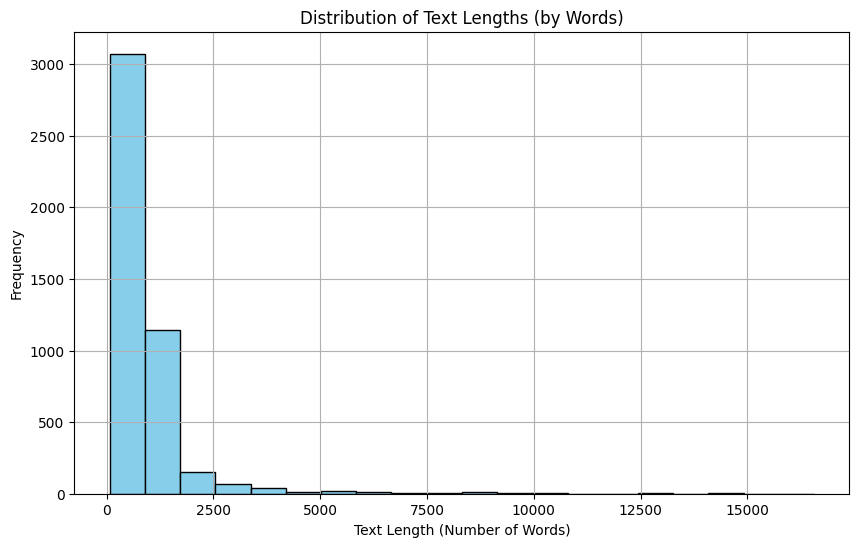

In [5]:
# Calculate length of each text (in terms of words)
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Plot distribution of text lengths
plt.figure(figsize=(10,6))
plt.hist(df['text_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths (by Words)')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
df.text_length.min()

73

# Pre-Processing

* Normalization
* TF-IDF

## Normalization

In [7]:
# Normalize First

## CONVERT TO LOWERCASE
def to_lowercase(text):
    text = text.lower()
    return text

#df['review'] = df['review'].apply(to_lowercase)

# ------------------------------------------------------------------------------------------------ #
## REMOVE NUMBERS
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

#df['review'] = df['review'].apply(remove_numbers)

# ------------------------------------------------------------------------------------------------ #
## REMOVE PUNCTUATION
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#df['review'] = df['review'].apply(remove_punctuations)

# ------------------------------------------------------------------------------------------------ #
## REMOVE SPECIAL CHARACTERS
def remove_special_chars(text):
    return re.sub('[^a-zA-Z]', ' ', text)

#df['review'] = df['review'].apply(remove_special_chars)

# ------------------------------------------------------------------------------------------------ #
## REMOVE UNNECESSARY WHITE SPACE
def remove_whitespace(text):
    return  " ".join(text.split())

#df['review'] = df['review'].apply(remove_whitespace)

# ------------------------------------------------------------------------------------------------ #
## REMOVE STOPWORDS

# create list of your own words to also remove
my_stopwords = ['br', 'b']

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english') + my_stopwords
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

#df['review'] = df['review'].apply(remove_stopwords)


# ------------------------------------------------------------------------------------------------ #
## LEMMATIZATION
# usually preferred over stemming
# considers context (word part of speech)
# caring -> care

#lem_df = df.copy()

# Part of speech tagger function
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    #word_tokens = word_tokenize(text)
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_review = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_review.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_review.append(lemmatizer.lemmatize(word, tag))
    lemmatized_review = " ".join(lemmatized_review)
    return lemmatized_review

#lem_df['review'] = lem_df['review'].apply(lemmatize_word)

# Twitter Specific Cleaning
def remove_hyperlinks(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)

def remove_hashtag_symbol(text):
    return re.sub(r'#', ' ', text)

def remove_retweet_text(text):
    return re.sub(r'^RT[\s]+', ' ', text)

# ---------------------------------------------------------------------------------------------------------------------------- #
## CUSTOM NORMALIZATION FUNCTION

# choose which preprocessing functions to use
# not using lemmatization or stemming since using a neural network
def custom_normalization(reviews):
    reviews = reviews.apply(to_lowercase)
    reviews = reviews.apply(remove_numbers)
    reviews = reviews.apply(remove_punctuations)
    reviews = reviews.apply(remove_special_chars)
    reviews = reviews.apply(remove_stopwords)
    # reviews = reviews.apply(remove_hyperlinks)
    # reviews = reviews.apply(remove_hashtag_symbol)
    # reviews = reviews.apply(remove_retweet_text)
    reviews = reviews.apply(lemmatize_word)
    return reviews

df['text'] = custom_normalization(df['text'])

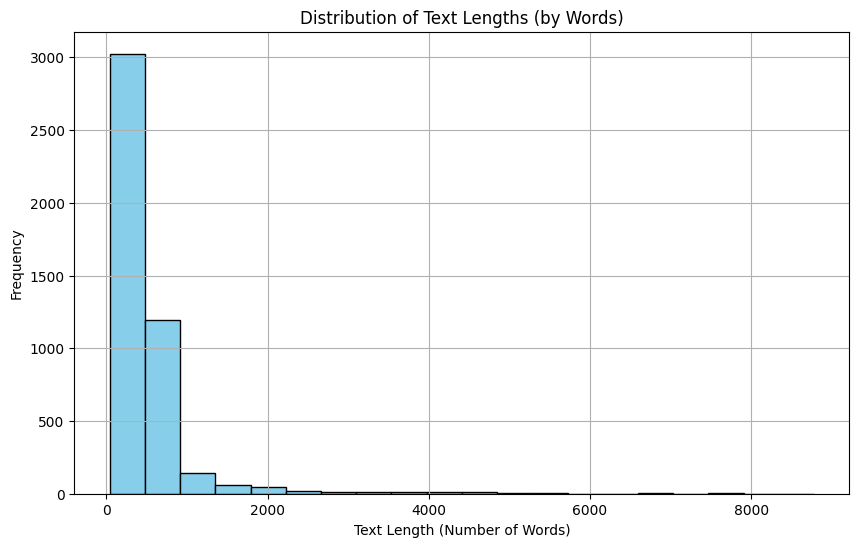

In [8]:
# Calculate length of each text (in terms of words)
df['text_length_normalized'] = df['text'].apply(lambda x: len(x.split()))

# Plot distribution of text lengths
plt.figure(figsize=(10,6))
plt.hist(df['text_length_normalized'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths (by Words)')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
df.text_length_normalized.min()

40

# Modeling

## LDA

Use bag of words with LDA

### Determine Optimal Number of Topics

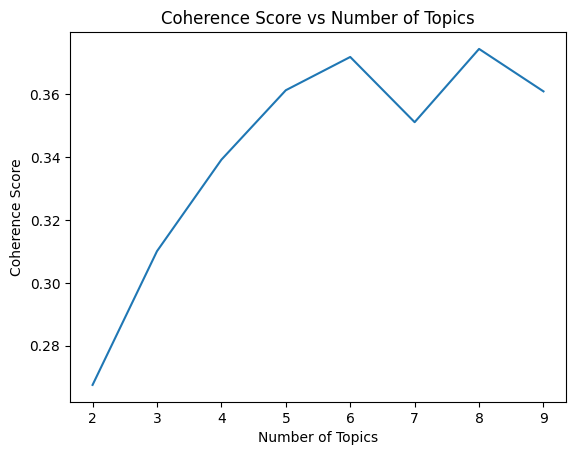

The optimal number of topics is: 8


In [22]:
def tokenize(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    return tokens

df['tokenized_text'] = df['text'].apply(tokenize)

# Create the dictionary and corpus required by Gensim
dictionary = corpora.Dictionary(df['tokenized_text'])

# Ensure that cleaned_article returns a list of tokens
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]

# Step 3: Compute Coherence Scores for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Step 4: Coherence score calculation and visualization
start = 2  # Minimum number of topics
limit = 10  # Maximum number of topics to try
step = 1    # Increment step

# Find the optimal number of topics by iterating over the range of topic numbers
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                        texts=df['tokenized_text'], 
                                                        start=start, limit=limit, step=step)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

# Find the number of topics with the highest coherence score
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_number_of_topics = start + optimal_index * step

print(f"The optimal number of topics is: {optimal_number_of_topics}")

LDA with optimal number of topics

In [30]:
# Run LDA with the optimal number of topics
optimal_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_number_of_topics, random_state=42)

# Print the topics
for idx, topic in optimal_model.print_topics(num_topics=optimal_number_of_topics):
    print(f"Topic {idx}: {topic}")

# Step 5: Visualize the topics

# Prepare the data for visualization
vis_data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)

# Visualize the topics
# pyLDAvis.show(vis_data)
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

Topic 0: 0.009*"say" + 0.006*"one" + 0.006*"people" + 0.005*"film" + 0.005*"get" + 0.005*"make" + 0.004*"year" + 0.004*"like" + 0.004*"go" + 0.004*"work"
Topic 1: 0.016*"say" + 0.010*"eu" + 0.009*"would" + 0.008*"leave" + 0.006*"people" + 0.006*"make" + 0.005*"uk" + 0.005*"vote" + 0.004*"year" + 0.004*"one"
Topic 2: 0.021*"trump" + 0.015*"say" + 0.008*"clinton" + 0.005*"like" + 0.005*"get" + 0.005*"campaign" + 0.005*"donald" + 0.005*"go" + 0.005*"one" + 0.005*"people"
Topic 3: 0.008*"league" + 0.007*"say" + 0.006*"one" + 0.005*"season" + 0.005*"team" + 0.004*"time" + 0.004*"goal" + 0.004*"go" + 0.004*"player" + 0.004*"game"
Topic 4: 0.007*"say" + 0.006*"year" + 0.005*"make" + 0.005*"go" + 0.005*"one" + 0.004*"music" + 0.004*"new" + 0.004*"time" + 0.003*"would" + 0.003*"work"
Topic 5: 0.014*"bank" + 0.011*"say" + 0.007*"would" + 0.007*"year" + 0.006*"financial" + 0.005*"uk" + 0.005*"bn" + 0.004*"business" + 0.004*"could" + 0.004*"market"
Topic 6: 0.016*"say" + 0.011*"trump" + 0.005*"yea

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; u

## NMF

* Use TF-IDF
* Can use SVD for dimensionality reduction, faster, better topics potentially

Get num words in dataset

In [5]:
# Ways to determine max_features (words)
# - tune it using optuna, start with like a range of 10% to 30%
# - get the distribution of words eliminate non-contributors

all_words = []
for headline in df['text']:
    for word in headline.split():
        all_words.append(word)
unique_words = set(all_words) # there are about 72297 unique words after normalization
print(len(unique_words))

72297


### Determine Optimal Number of Topics

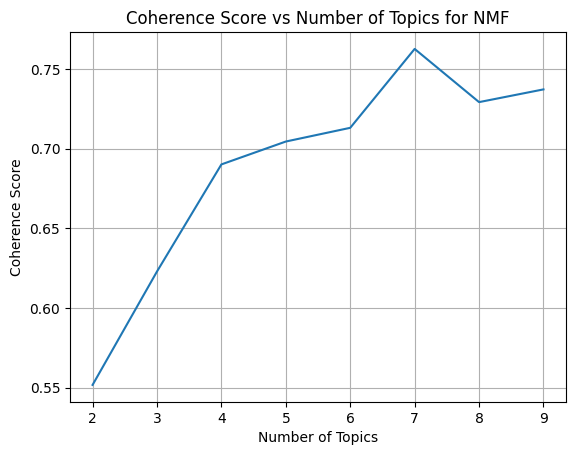

The optimal number of topics for NMF is: 7


In [9]:
# Step 1: Create TF-IDF representation with unigrams only
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=1000)  # Use unigrams only, code needs alteration to use other n_grams (gensim dictionary)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Get feature names for unigrams
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Create tokenized texts for the coherence model using unigrams
# Tokenize the original texts to match unigrams
tokenized_texts = [text.split() for text in df['text']]  # Original tokenization

# Create a Gensim Dictionary using the unigrams
gensim_dictionary = Dictionary(tokenized_texts)

# Step 3: Compute Coherence Scores for different numbers of topics
def compute_coherence_nmf(tfidf_matrix, texts, dictionary, start, limit, step):
    coherence_values = []
    model_list = []
    
    for n_topics in range(start, limit, step):
        nmf_model = NMF(n_components=n_topics, random_state=42)
        nmf_model.fit(tfidf_matrix)
        
        # Create the topic-word matrix
        topic_word_matrix = nmf_model.components_
        
        # Compute coherence score
        topics = []
        for topic in topic_word_matrix:
            topic_words = [feature_names[i] for i in topic.argsort()[-10:]]  # Top 10 words for each topic
            topics.append(topic_words)

        # Compute coherence score using the Gensim Dictionary
        coherencemodel = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        model_list.append(nmf_model)
    
    return model_list, coherence_values

# Step 4: Coherence score calculation and visualization
start = 2  # Minimum number of topics
limit = 10  # Maximum number of topics to try
step = 1    # Increment step

# Calculate coherence scores for different numbers of topics
model_list, coherence_values = compute_coherence_nmf(tfidf_matrix, tokenized_texts, gensim_dictionary, start, limit, step)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics for NMF")
plt.xticks(x)  # Ensure all ticks are shown
plt.grid()
plt.show()

# Find the number of topics with the highest coherence score
optimal_index = coherence_values.index(max(coherence_values))
optimal_number_of_topics = start + optimal_index * step

print(f"The optimal number of topics for NMF is: {optimal_number_of_topics}")

NMF with optimal number of topics

In [10]:
# Step 4: Run NMF with the optimal number of topics
optimal_nmf_model = NMF(n_components=optimal_number_of_topics, random_state=42)
optimal_nmf_model.fit(tfidf_matrix)

# Get the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(optimal_nmf_model.components_):
    top_words = topic.argsort()[-10:]  # Top 10 words for each topic
    print(f"Topic {topic_idx}: {[feature_names[i] for i in top_words]}")

Topic 0: ['cinema', 'hollywood', 'play', 'story', 'character', 'director', 'actor', 'star', 'movie', 'film']
Topic 1: ['hillary', 'election', 'candidate', 'state', 'campaign', 'say', 'donald', 'republican', 'clinton', 'trump']
Topic 2: ['minister', 'would', 'leave', 'referendum', 'say', 'britain', 'vote', 'uk', 'brexit', 'eu']
Topic 3: ['city', 'club', 'premier', 'team', 'leicester', 'player', 'goal', 'season', 'game', 'league']
Topic 4: ['share', 'business', 'rate', 'banking', 'market', 'say', 'customer', 'financial', 'bn', 'bank']
Topic 5: ['love', 'track', 'record', 'sound', 'like', 'pop', 'band', 'music', 'song', 'album']
Topic 6: ['child', 'doctor', 'mental', 'service', 'nhs', 'care', 'patient', 'people', 'say', 'health']


Assign Topics to New Articles

In [11]:
# Sample new articles (replace this with your actual new articles)
new_articles = [
    "The recent economic policies are expected to influence the market.",
    "Political stability is crucial for economic growth.",
    "Investments in renewable energy are increasing worldwide."
]

# Step 1: Preprocess new articles if needed
# For example, let's assume they are already cleaned and ready for TF-IDF

# Step 2: Transform new articles into TF-IDF representation
new_tfidf_matrix = tfidf_vectorizer.transform(new_articles)

# Step 3: Predict topics using the trained NMF model
topic_distributions_new = optimal_nmf_model.transform(new_tfidf_matrix)

# Step 4: Assign topics
assigned_topics_new = topic_distributions_new.argmax(axis=1)

# Create a DataFrame to see results
new_articles_df = pd.DataFrame({
    'article': new_articles,
    'assigned_topic': assigned_topics_new
})

print(new_articles_df)

                                             article  assigned_topic
0  The recent economic policies are expected to i...               4
1  Political stability is crucial for economic gr...               2
2  Investments in renewable energy are increasing...               2
